In [51]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from src.MinAggGNN import MinAggGNN
import matplotlib.pyplot as plt

device = torch.device('cuda')
L = 2
m = 2
eta = 0.0003
epochs = 20000

model = MinAggGNN(1, 8, L, 1, edge_dim = 1)
state_dict = torch.load('model_progress/model_final.pt')
# state_dict = torch.load('model_progress/unregularized/model_final.pt')
# state_dict = torch.load('model_progress/model_checkpoints.pt')[100]
model.load_state_dict(state_dict)
model.eval()
model.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


MinAggGNN(1, 1, num_layers=2)

In [52]:
from src.ComputationGraph import ComputationGraph, Circuit
from src.utils import MultiplicativeLoss
import torch_geometric as pyg
import networkx as nx

G = ComputationGraph(model)
G.add_inputs({'edge_attr' : [1, model.convs[0].agg_mlp.lins[0].weight[:,-1]],
              'input_self' : [3, model.convs[0].up_mlp.lins[0].weight[:,-1]]})
G.add_residual_connections({'edge_attr' : [5, model.convs[1].agg_mlp.lins[0].weight[:,-1].reshape(1,-1).cpu().detach()]})
G.add_residual_connections({4 : [7, model.convs[1].up_mlp.lins[0].weight[:,-8:].T.cpu().detach()]})

In [53]:
# criterion = MultiplicativeLoss()
criterion = torch.nn.MSELoss()
test_data = torch.load('data/test_data.pt', map_location=device)
corrupted_data = torch.load('data/test_data.pt', map_location=device)
for data_corr in corrupted_data:
    data_corr.x = torch.zeros_like(data_corr.x, device=device)
    data_corr.x[0] = 100.
    data_corr.edge_attr = torch.zeros_like(data_corr.edge_attr, device=device)

G.calculate_scores(test_data, corrupted_data, criterion, which = 'EAP')
G.calculate_scores(test_data, corrupted_data, criterion, which = 'EAP-IG', steps=5)

In [84]:
# which = 'weight'
# which = 'EAP'
which = 'EAP-IG'
K = 7
C = Circuit(model, G, K=K, key=which)

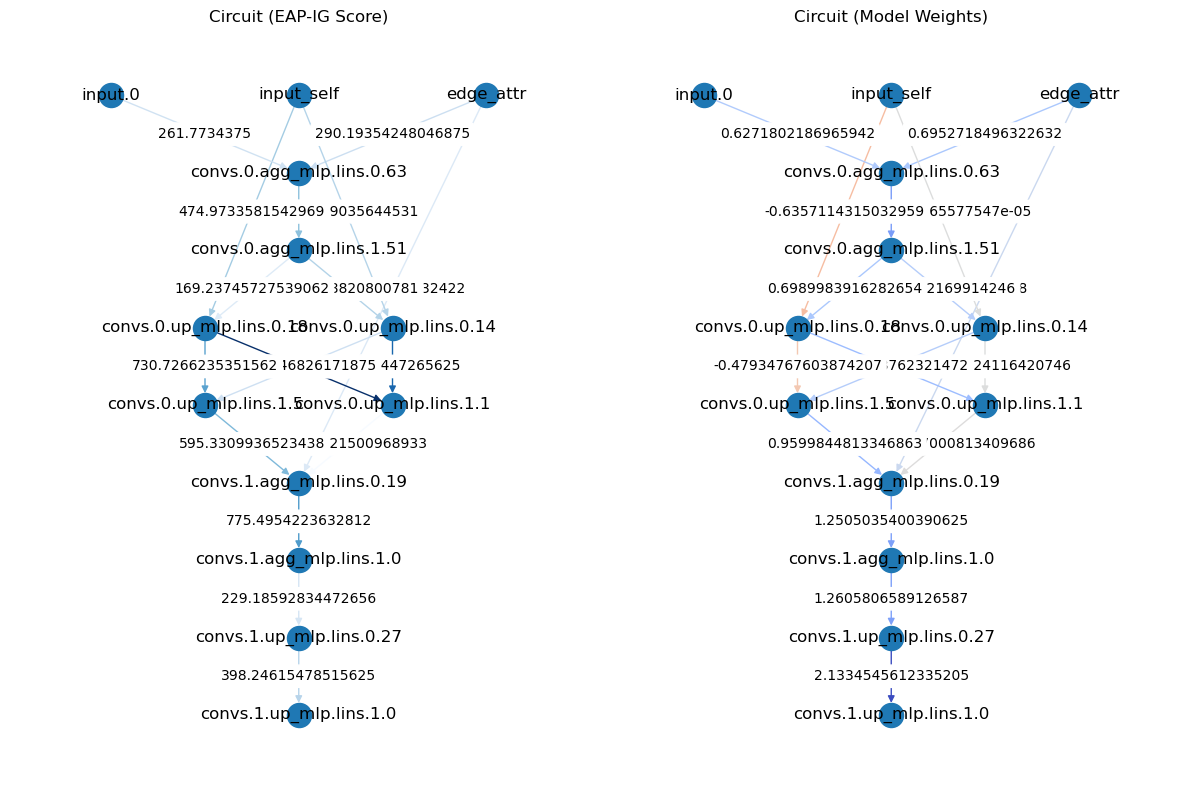

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
c_pos = nx.multipartite_layout(C, subset_key='layer', align='horizontal')
c_pos = {node: (x,-y) for (node, (x,y)) in c_pos.items()}

circuit_edges, circuit_edge_scores = zip(*nx.get_edge_attributes(C,which).items())
nx.draw(C, pos = c_pos, ax=ax[0],
        edgelist=circuit_edges,
        edge_color=circuit_edge_scores,
        edge_cmap=plt.cm.Blues,
        with_labels=True
        )
nx.draw_networkx_edge_labels(C, pos = c_pos, ax=ax[0],
                             edge_labels=nx.get_edge_attributes(C,which),
                             rotate=False)
ax[0].set_title(f'Circuit ({which} Score)')

_, circuit_edge_weights = zip(*nx.get_edge_attributes(C,'weight').items())
abs_vmax = abs(max(circuit_edge_weights, key=abs))
nx.draw(C, pos = c_pos, ax=ax[1],
        edgelist = circuit_edges,
        edge_color = circuit_edge_weights,
        edge_cmap=plt.cm.coolwarm.reversed(),
        with_labels = True,
        edge_vmax = abs_vmax,
        edge_vmin = -abs_vmax
        )
nx.draw_networkx_edge_labels(C, pos = c_pos, ax=ax[1],
                             edge_labels=nx.get_edge_attributes(C,'weight'),
                             rotate=False)
ax[1].set_title('Circuit (Model Weights)')

ax[0].margins(x=.2)
ax[1].margins(x=.2)
plt.tight_layout()

In [86]:
test_loader = pyg.loader.DataLoader(test_data, batch_size = len(test_data))
criterion = MultiplicativeLoss()

In [87]:
checkpoints = torch.load('model_progress/model_checkpoints.pt')
circuit_losses = []
for checkpoint in checkpoints:
    model.load_state_dict(checkpoint)
    C.model_state_dict = checkpoint
    for data in test_loader:
        out = C.forward(data).flatten()
        circuit_losses.append(float(criterion(out[data.reachable], data.y[data.reachable]).detach()) / len(test_data))

In [88]:
mse_losses = torch.load('model_progress/mse_losses.pt')
l1_regs = torch.load('model_progress/l1_regs.pt')
test_losses = torch.load('model_progress/test_losses.pt')

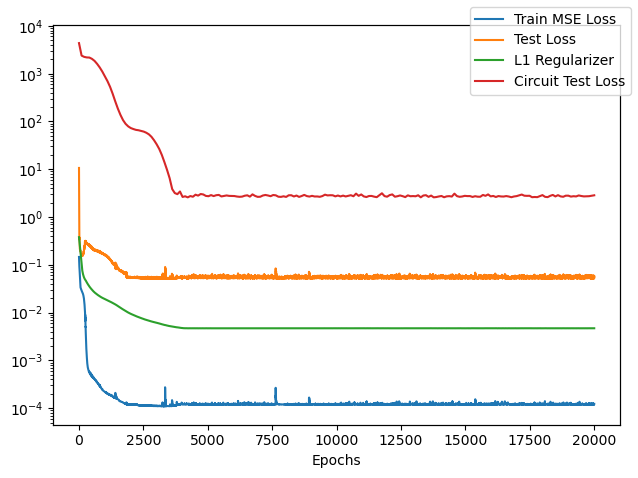

In [89]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(mse_losses.detach(), label='Train MSE Loss')
ax.plot(test_losses.detach(), label='Test Loss')
ax.plot((eta * l1_regs).detach(), label='L1 Regularizer')
ax2 = ax.twiny()
ax2.plot(circuit_losses, color='tab:red', label='Circuit Test Loss')
ax2.set_xticks([])
ax.set_yscale('log')
ax.set_xlabel('Epochs')
fig.legend()
plt.tight_layout()